In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [10]:
# connect to MetaTrader 5
try:
    import MetaTrader5 as mt5
    if not mt5.initialize():
        print("initialize() failed")
        mt5.shutdown()
        gold_data = pd.read_csv("gold_data.csv")
    else:
        # request connection status and parameters
        print(mt5.terminal_info())
        # get data on MetaTrader 5 version
        print(mt5.version())
        gold_ticks = mt5.copy_rates_from_pos("GOLD", mt5.TIMEFRAME_M5, 0, 100000)
        # shut down connection to MetaTrader 5
        mt5.shutdown()
        gold_data = pd.DataFrame(gold_ticks)
        gold_data.to_csv("gold_data.csv")
except Exception as e:
    print(e)
    if os.path.exists("gold_data.csv"):
        gold_data = pd.read_csv("gold_data.csv")
    else:
        print("gold_data.csv not found, no way to retrieve the data. Exiting...")
        exit()

TerminalInfo(community_account=True, community_connection=True, connected=True, dlls_allowed=True, trade_allowed=False, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=True, mqid=True, build=4570, maxbars=100001, codepage=0, ping_last=197422, community_balance=0.0, retransmission=0.06814451377408019, company='MetaQuotes Ltd.', name='MetaTrader 5', language='English', path='C:\\Program Files\\MetaTrader 5', data_path='C:\\Users\\rossb\\AppData\\Roaming\\MetaQuotes\\Terminal\\D0E8209F77C8CF37AD8BF550E51FF075', commondata_path='C:\\Users\\rossb\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')
(500, 4570, '27 Sep 2024')


In [11]:
# Trading hour is influential on price, so we get time of day data. ( from 01:00:00 to 23:59:59 )

time = (gold_data['time'] % (24 * 60 * 60) - 3600) / ((23 * 60 * 60)) * 2 * np.pi
gold_data['time_sin'] = np.sin(time)
gold_data['time_cos'] = np.cos(time)

numeric_feature_names = ['open', 'high', 'low', 'close', 'tick_volume', 'time_sin', 'time_cos']
gold_data = gold_data[numeric_feature_names]
gold_data.head()

,open,high,low,close,tick_volume,time_sin,time_cos
0,2014.52,2015.08,2014.45,2014.91,287,-0.699012,0.715110
1,2014.89,2015.40,2014.68,2015.34,265,-0.682553,0.730836
2,2015.32,2015.74,2014.83,2014.87,335,-0.665740,0.746184
3,2014.84,2015.12,2014.33,2014.88,394,-0.648582,0.761145
4,2014.80,2014.89,2013.88,2013.88,280,-0.631088,0.775711


In [12]:
column_indices = {name: i for i, name in enumerate(gold_data.columns)}

n = len(gold_data)
train_df = gold_data[0:int(n*0.7)]
val_df = gold_data[int(n*0.7):int(n*0.9)]
test_df = gold_data[int(n*0.9):]

num_features = gold_data.shape[1]

In [13]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

C:\Users\rossb\AppData\Local\Temp\ipykernel_15796\4164704403.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(gold_data.keys(), rotation=90)


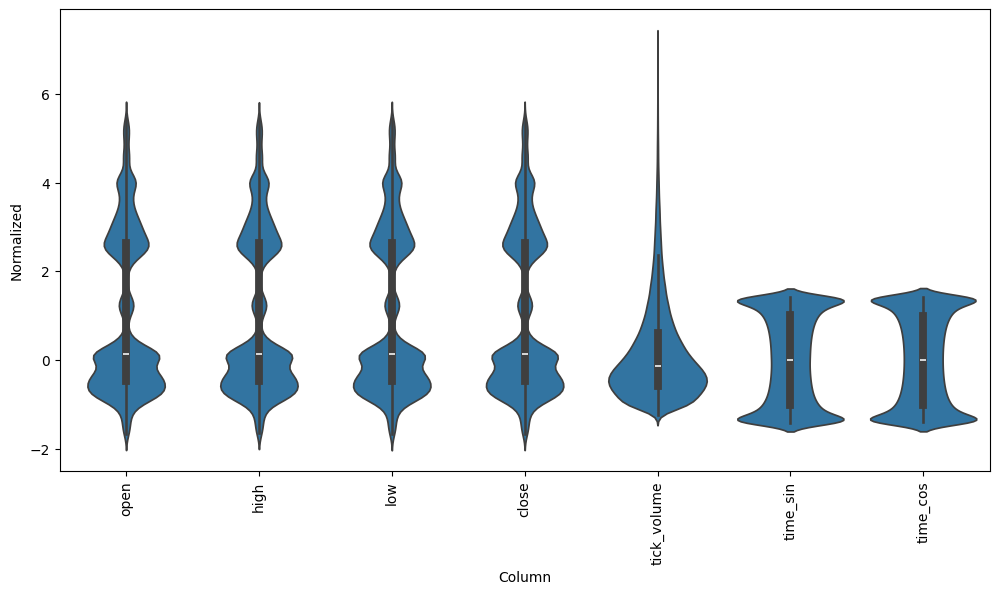

In [14]:
import seaborn as sns
df_std = (gold_data - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(gold_data.keys(), rotation=90)

In [30]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
  def plot(self, model=None, plot_col='close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result


In [31]:
window = WindowGenerator(input_width=12 * 20, label_width=12 * 3, shift=1)

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

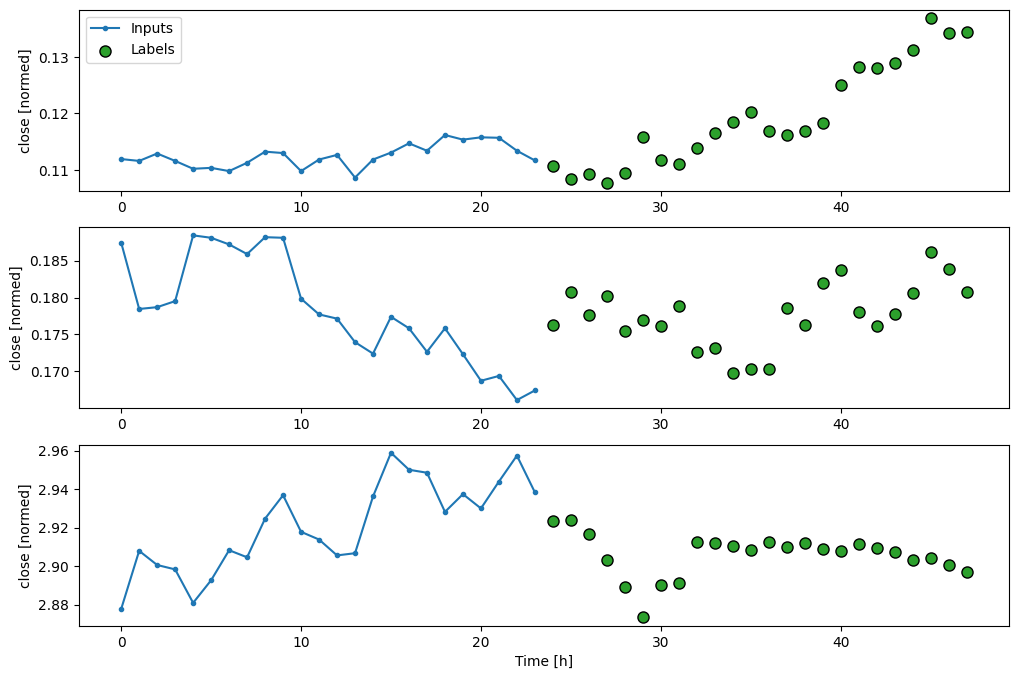

In [32]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [33]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)
  def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state
  def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [39]:
MAX_EPOCHS = 30

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [35]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 7])

In [43]:
history = compile_and_fit(feedback_model, multi_window)
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

Epoch 1/30
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.0409 - mean_absolute_error: 0.0764 - val_loss: 0.1037 - val_mean_absolute_error: 0.1640
Epoch 2/30
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0411 - mean_absolute_error: 0.0763 - val_loss: 0.0903 - val_mean_absolute_error: 0.1428
Epoch 3/30
2187/2187 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0402 - mean_absolute_error: 0.0745 - val_loss: 0.0927 - val_mean_absolute_error: 0.1495
Epoch 4/30
1546/2187 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0402 - mean_absolute_error: 0.0749

KeyboardInterrupt: 

In [42]:
history.history

{'loss': [0.04220443591475487, 0.04155869409441948, 0.04126594960689545],
 'mean_absolute_error': [0.07793818414211273,
  0.0768159031867981,
  0.07656816393136978],
 'val_loss': [0.10346652567386627, 0.11153336614370346, 0.1083572655916214],
 'val_mean_absolute_error': [0.16958945989608765,
  0.1633882373571396,
  0.16861778497695923]}

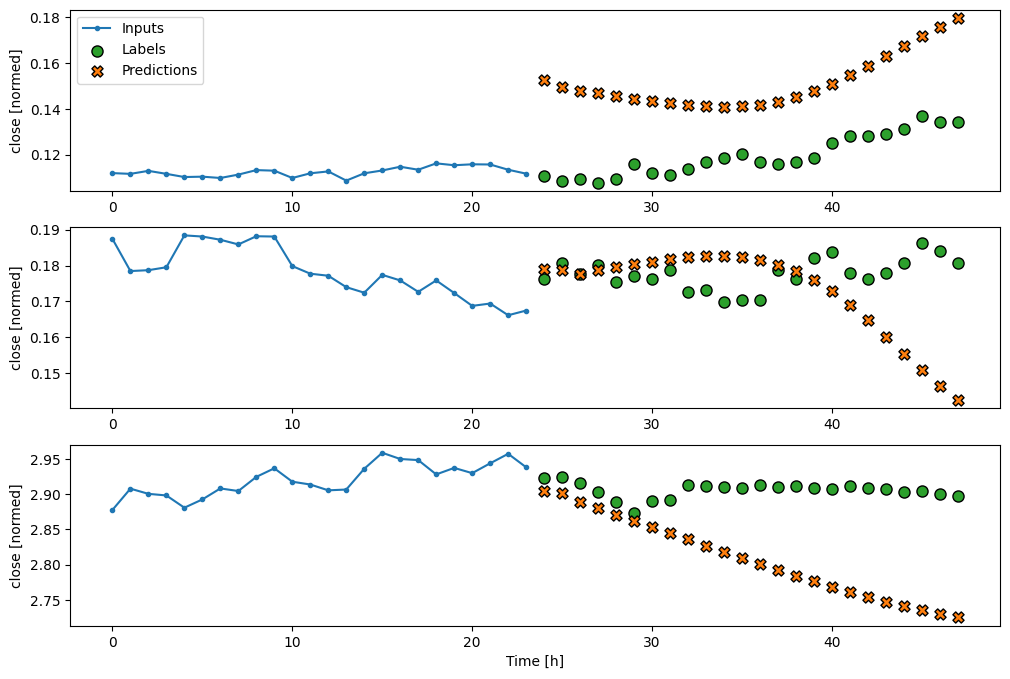

In [38]:

multi_window.plot(feedback_model)